In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

In [2]:
START_DATE = '2003-3-31'
END_DATE = '2009-3-31'

## import

In [3]:
import talib
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import plotly.graph_objs as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta



from dataframe import CustomDataFrame

import plot_data

---

---

---

## get data

In [ ]:
data=Data()

In [5]:
data_us=Data(market="US")

---

## 資料下載

### **盈餘再投資率**

In [5]:
profit = data.get('annual_report_fundamentals:常續性稅後淨利')

In [6]:
# plot_data.numeric_bins(profit, "稅後淨利逐年數值分佈", stacked=True, num_label=True,
#                 bins=[-np.inf, 0, 500000, np.inf], 
#                 labels=['負值', '0~5億', '5億以上'])

In [7]:
# 抓資料
long_term_items = [
    '透過損益按公允價值衡量之金融資產－非流動', #2005
    '透過其他綜合損益按公允價值衡量之金融資產－非流動', #2005
    '按攤銷後成本衡量之金融資產－非流動', #2005
    '避險之金融資產－非流動', #2005
    '合約資產－非流動', #2017
    '採權益法之長期股權投資',
    '預付投資款', #2005
    '投資性不動產淨額'
]

# 長期投資項目 (8個)
long_term_data = [data.get(f'annual_report_fundamentals:{item}').fillna(0) for item in long_term_items]
long_term_investment = sum(long_term_data)
# 固定資產
fixed_assets_year = data.get('annual_report_fundamentals:不動產廠房及設備').fillna(0)

In [8]:
rr_sum = data.get('annual_report_fundamentals:非流動資產') #.fillna(0)

In [9]:
# rr_sum

In [10]:
rr_sum_df = rr_sum - rr_sum.shift(4)

In [12]:
# test = data.get('annual_report_fundamentals:不動產廠房及設備')
# test.notna().sum(axis=1).plot()

In [13]:
# 計算盈再率分子
long_term_investment_df = (long_term_investment - long_term_investment.shift(4))
fixed_assets_df = (fixed_assets_year - fixed_assets_year.shift(4))

In [14]:
profit_rol_df = profit.rolling(4).sum()

In [71]:
# 計算出盈再率
# 去掉淨利為負的公司 (當年度淨利為負、四年加總淨利為負都去掉)
orig_rr = (long_term_investment_df + fixed_assets_df) / profit_rol_df
orig_rr = orig_rr[(profit > 0) & (profit_rol_df > 0)]['2009':]

old_rr = rr_sum_df / profit_rol_df
old_rr = old_rr[(profit > 0) & (profit_rol_df > 0)][:'2008']

common_columns = sorted(list(set(orig_rr.columns) & set(old_rr.columns)))
# 合併資料
rr = pd.concat([old_rr[common_columns], orig_rr[common_columns]])

rr

company_symbol,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-31,8.300768,1.245832,3.717276,0.987052,-0.193206,0.282010,1.848552,NaN,NaN,4.410958,...,1.109336,NaN,NaN,NaN,0.729640,NaN,NaN,1.272429,NaN,NaN
1999-03-31,10.361118,0.993799,NaN,0.149234,-0.776421,0.267587,2.146137,NaN,NaN,3.803985,...,-0.085216,NaN,NaN,NaN,NaN,3.076410,NaN,1.930809,NaN,NaN
2000-03-31,13.744968,1.177991,NaN,-0.655417,-0.891752,0.114323,2.759842,NaN,NaN,1.642418,...,0.247863,NaN,NaN,0.263192,4.881643,4.141837,NaN,0.508218,NaN,8.098450
2001-03-31,NaN,0.981544,NaN,0.170908,NaN,0.448240,NaN,NaN,NaN,1.369873,...,0.385548,NaN,2.814245,0.316606,NaN,2.422758,2.878287,0.330014,NaN,3.213813
2002-03-31,NaN,1.529271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.115576,...,1.089505,NaN,0.128580,0.284576,43.498054,1.510449,2.711080,NaN,NaN,-0.555858
2003-03-31,NaN,3.005175,NaN,25.807640,NaN,0.459786,5.507610,NaN,NaN,0.804104,...,1.266114,NaN,0.298512,0.369946,2.311996,0.687961,1.202436,NaN,NaN,-0.593396


### 盈再率 - 數值分佈

In [17]:
# plot_data.numeric_bins(rr, "盈餘再投資率逐年數值分佈", stacked=True, num_label=True,
#                 bins=[-np.inf, 0, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, np.inf], 
#                 labels=['負值' ,'0-40%', '40-80%', '80-120%', '120-160%', '160-200%', '200-240%', '240-280%', '280-320%', '320%以上'])

---

### **本益比 (P/E)**
- 每季資料
- 每日資料

In [6]:
pe = data.get('quarter_report:PE') #[START_DATE:END_DATE]
daily_pe = data.get('price:daily_pe') #[START_DATE:END_DATE]

In [7]:
us_pe = data_us.get('quarter_report:PE')

In [ ]:
# us_pe.to_csv('us_pe_test.csv')

### **其他因子**

- ROE (季資料，取第四季)
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- 董監持股 (沒有每年的資料，缺值採向前補值)
- 上市上櫃滿兩年

In [19]:
roe = data.get('annual_report:ROE')
payout_ratio = data.get('annual_report_fundamentals:股利支付率')

In [20]:
stock_hold = data.get('annual_report_fundamentals:董監持股%')

In [21]:
# listed_date = pd.read_csv('../2024_code/最近上市日.csv', encoding='cp950')

##### 上市上櫃滿兩年

In [22]:
close = data.get('price:close')
comp_profile = data.get('company_profile')



stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 80%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [23]:
# ROE 5年平均 > 15%
roe_rol = roe.rolling(5).mean()
roe_15 = (roe_rol > 15)

In [24]:
rr_cond = (rr < 0.4)

In [25]:
# *最近3年的配息率有無一年不及40%*
payout_ratio_cond = (payout_ratio.rolling(3).min() >= 40)

# # 金融股看配息率，不看盈再率
# rr_cond[finance_stock_list] = payout_ratio_cond[finance_stock_list]

In [26]:
# 淨利 > 5億
profit_cond = (profit > 500000) # TEJ 的淨利單位是千元

In [27]:
hold_cond = stock_hold > 10

In [28]:
listed = listed.resample('M').last()

---

---

## 原始條件 + 無本益比進出場條件

In [29]:
orig_all_cond = roe_15 & rr_cond & payout_ratio_cond & profit_cond & hold_cond & listed

---

## 原始條件 + 有本益比進出場

### 每季本益比進出場

In [30]:
# (每季)本益比條件

pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

In [31]:
orig_all_cond_and_pe = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit[START_DATE:END_DATE])

### **每月本益比進出場**

In [32]:
# 每日本益比resample成每月
daily_pe_resample = daily_pe.resample('M').last()

pe_cond_entry_daily = daily_pe_resample < 12
pe_cond_exit_daily = daily_pe_resample > 30

In [33]:
orig_all_cond_and_pe_daily = ((orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE]))

# rep_all_cond_and_pe_daily = backtest.sim(orig_all_cond_and_pe_daily, resample='M', data=data)
# rep_all_cond_and_pe_daily.display()

In [34]:
# all_cond_pos_ret, all_cond_neg_ret = rep_all_cond_and_pe_daily.calc_returns_contrib(5)

---

---

## 綜合比較入選股數變化

In [35]:
all_cond_reps = {}

all_cond_reps['原始條件_無本益比'] = orig_all_cond[START_DATE:END_DATE]
all_cond_reps['原始條件_無本益比_ROE出場條件'] = orig_all_cond[START_DATE:END_DATE] & (roe[START_DATE:END_DATE] > 15)
# all_cond_reps['原始條件_無本益比_布林通道'] = orig_all_cond[START_DATE:END_DATE] & bolling_1_filt[START_DATE:END_DATE]
# all_cond_reps['原始條件_無本益比_ROE出場條件_布林通道'] = orig_all_cond[START_DATE:END_DATE] & bolling_1_filt[START_DATE:END_DATE] & (roe[START_DATE:END_DATE] > 15)

# all_cond_reps['原始條件_每季本益比'] = orig_all_cond_and_pe[START_DATE:END_DATE]
all_cond_reps['原始條件_有本益比'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]
all_cond_reps['原始條件_有本益比_ROE出場條件'] = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 15))
# all_cond_reps['原始條件_有本益比_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | ~bolling_1_filt[START_DATE:END_DATE])
# all_cond_reps['原始條件_有本益比_ROE出場條件_布林通道'] = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | ~bolling_1_filt[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 15)) 


# all_cond_reps['原始條件_無本益比進出場_2009~2024'] = orig_all_cond['2009-3':'2024']
# all_cond_reps['原始條件_每季本益比_2009~2024'] = (orig_all_cond['2009-3':'2024'] & pe_cond_entry['2009-3':'2024']).hold_until((~orig_all_cond['2009-3':'2024']) | pe_cond_exit['2009-3':'2024'])
# all_cond_reps['原始條件_每日本益比_2009~2024'] = ((orig_all_cond['2009-3':'2024'] & pe_cond_entry_daily['2009-3':'2024']).hold_until((~orig_all_cond['2009-3':'2024']) | pe_cond_exit_daily['2009-3':'2024']))


rep_collecs = sim_conditions(all_cond_reps, resample='M', data=data)


# all_cond_reps_2003_09 = {}

# all_cond_reps_2003_09['原始條件_無本益比進出場_2003_09'] = orig_all_cond[START_DATE:END_DATE]
# all_cond_reps_2003_09['原始條件_每季本益比_2003_09'] = orig_all_cond_and_pe[START_DATE:END_DATE]
# all_cond_reps_2003_09['原始條件_每日本益比_2003_09'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]

# all_cond_reps_2009_24 = {}

# all_cond_reps_2009_24['原始條件_無本益比進出場_2009_24'] = orig_all_cond[2009:2024]
# all_cond_reps_2009_24['原始條件_每季本益比_2009_24'] = orig_all_cond_and_pe[2009:2024]
# all_cond_reps_2009_24['原始條件_每日本益比_2009_24'] = orig_all_cond_and_pe_daily[2009:2024]


# rep_collecs_2003_09 = sim_conditions(all_cond_reps_2003_09, resample='M', data=data)
# rep_collecs_2009_24 = sim_conditions(all_cond_reps_2009_24, resample='M', data=data)


Backtesting progress: 100%|██████████| 4/4 [00:11<00:00,  2.96s/condition]


In [36]:
rep_collecs.selected_stock_count_analysis()

,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
原始條件_有本益比_ROE出場條件,13.61,-55.20,19.96,22.0,5.0,32.0,1.0,45.0
原始條件_無本益比_ROE出場條件,12.62,-55.34,22.73,26.0,5.0,36.0,2.0,47.0
原始條件_有本益比,11.38,-55.38,22.56,25.0,6.0,36.0,2.0,49.0
原始條件_無本益比,10.74,-54.84,25.52,29.0,6.0,41.0,3.0,52.0


In [37]:
rep_collecs.reports['原始條件_有本益比_ROE出場條件'].display()

,annualized_rate_of_return,sharpe,max_drawdown,win_ratio
,13.61%,45.45,-55.2%,41.3%


,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,entry_index,exit_index,return,mae,gmfe,bmfe,mdd,pdays,weight,next_weights
stock_id,,,,,,,,,,,,,,,,
1303,2007-05-02,2009-04-01,2007-04-30,2009-03-31,0.032258,476,1834,2310,-0.235580,-0.381420,0.723721,0.723721,-0.641137,318.0,0.000000,0.000000
1477,2005-04-01,2009-04-01,2005-03-31,2009-03-31,0.076923,991,1319,2310,0.145771,-0.260041,2.106229,2.106229,-0.761782,838.0,0.000000,0.000000
1710,2008-07-01,2009-04-01,2008-06-30,2009-03-31,0.026316,186,2124,2310,-0.411216,-0.580895,0.132357,0.132357,-0.629883,12.0,0.000000,0.000000
2002,2005-04-01,2009-04-01,2005-03-31,2009-03-31,0.076923,991,1319,2310,0.100460,-0.210383,1.376140,0.015704,-0.572777,757.0,0.000000,0.000000
2006,2008-07-01,2009-04-01,2008-06-30,2009-03-31,0.026316,186,2124,2310,-0.462814,-0.665079,0.021819,0.021819,-0.672230,2.0,0.000000,0.000000
2027,2007-05-02,2009-04-01,2007-04-30,2009-03-31,0.032258,476,1834,2310,-0.643627,-0.745723,0.103093,0.103093,-0.769487,42.0,0.000000,0.000000
2404,2008-04-01,2009-04-01,2008-03-31,2009-03-31,0.031250,249,2061,2310,-0.473367,-0.583877,0.024427,0.024427,-0.593799,26.0,0.000000,0.000000
2439,2008-04-01,2009-04-01,2008-03-31,2009-03-31,0.031250,249,2061,2310,-0.501482,-0.649066,0.262689,0.262689,-0.722074,47.0,0.000000,0.000000
2603,2008-07-01,2009-04-01,2008-06-30,2009-03-31,0.026316,186,2124,2310,-0.286307,-0.395970,0.051111,0.051111,-0.425341,7.0,0.000000,0.000000


In [38]:
_,_=rep_collecs.reports['原始條件_有本益比'].calc_returns_contrib()

---

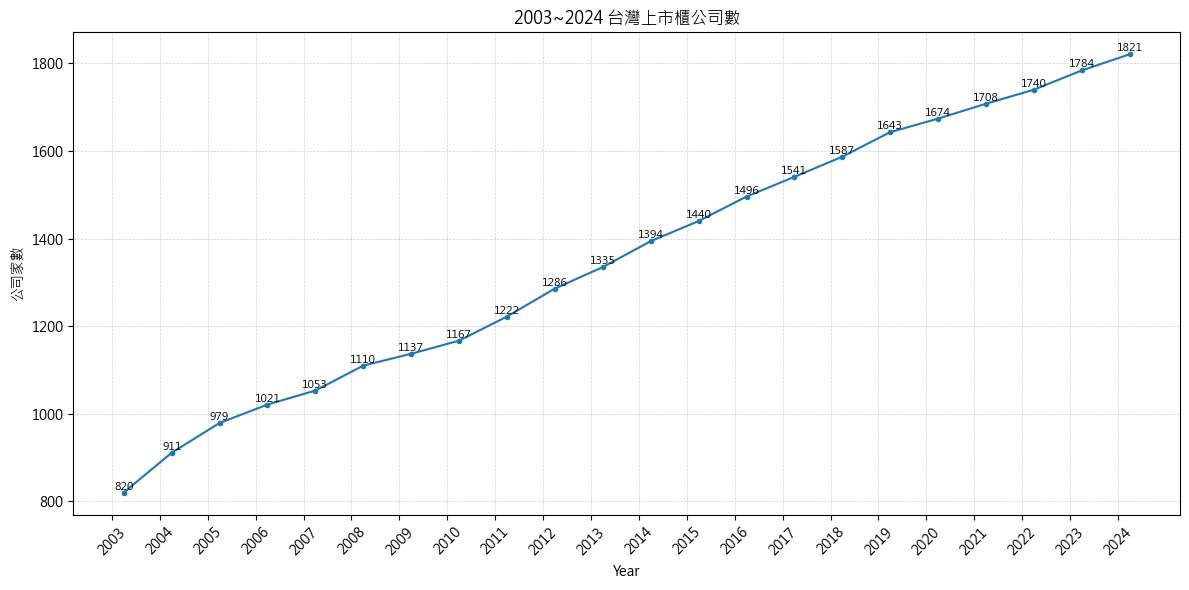

In [39]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = close['2003':'2024-3']
x = plot_data.resample('A-MAR').last().index  # X 軸
y = plot_data.notna().sum(axis=1).resample('A-MAR').last()  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2003~2024 台灣上市櫃公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


In [40]:
# plt.figure(figsize=(12, 6))

# # 完整資料
# x_full = close['2003':'2024-3'].index  # X 軸完整資料
# y_full = close['2003':'2024-3'].notna().sum(axis=1)  # Y 軸完整資料

# # Resample 的資料（每年三月底）
# x_resampled = close['2003':'2024-3'].resample('A-JAN').last().index  # Resample 的 X 軸
# y_resampled = close['2003':'2024-3'].notna().sum(axis=1).resample('A-JAN').last()  # Resample 的 Y 軸

# # 繪製完整資料的折線圖
# plt.plot(x_full, y_full, linestyle='-', linewidth=1, label='Daily Data')

# # 在 Resample 點添加 marker
# plt.plot(x_resampled, y_resampled, marker='o', linestyle='', markersize=3, color='tab:blue')

# # 為 Resample 點添加數字標籤
# for i, value in enumerate(y_resampled):
#     plt.text(x_resampled[i], y_resampled.iloc[i], str(value), ha='center', va='bottom', fontsize=8, color='black')

# # 設置標籤和樣式
# plt.xlabel("Year")
# plt.ylabel("公司家數")
# plt.title("2003~2024 台灣上市櫃公司數")
# plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
# plt.xticks(
#     ticks=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS"),
#     labels=pd.date_range(start="2003-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
#     rotation=45
# )

# # 顯示圖例
# plt.legend()
# plt.tight_layout()
# plt.show()


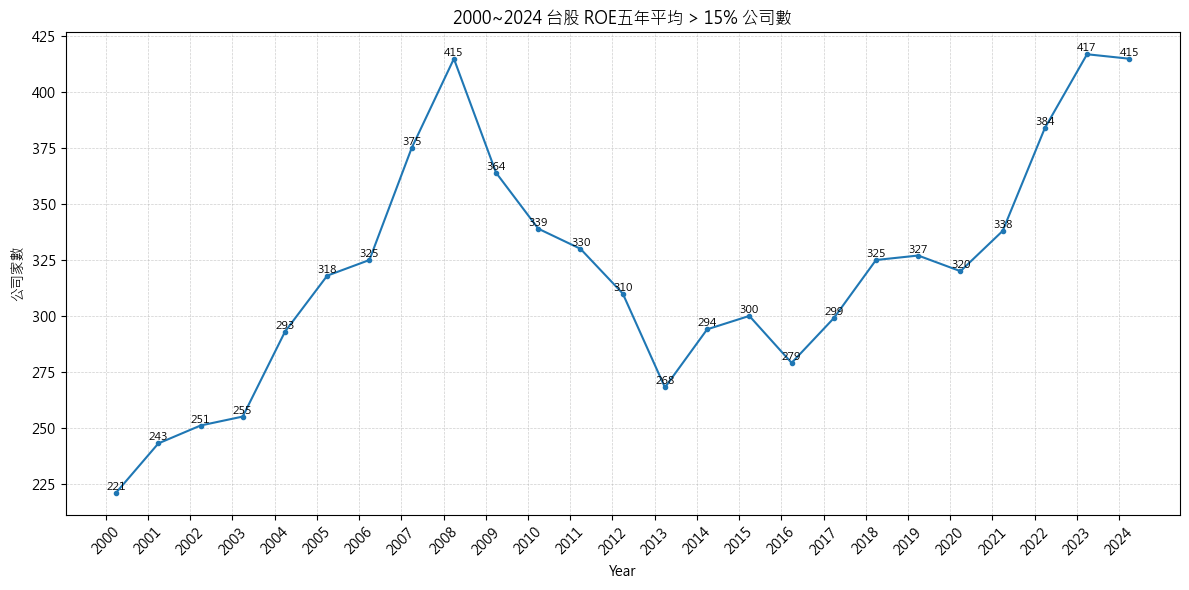

In [41]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = roe_15['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 ROE五年平均 > 15% 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


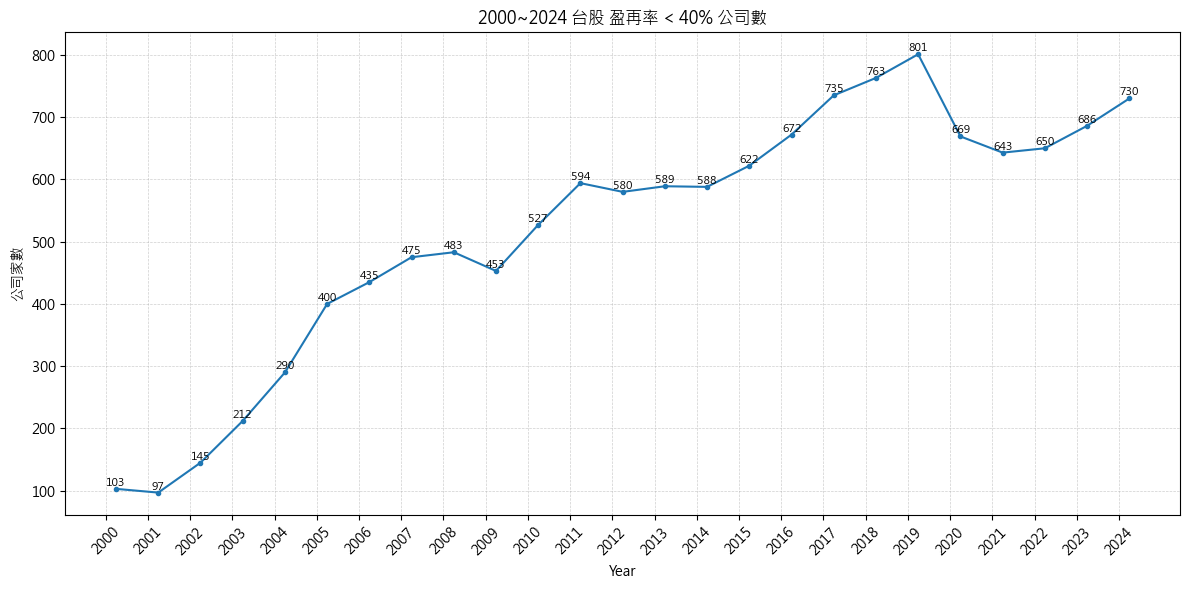

In [42]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = rr_cond['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 盈再率 < 40% 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


In [43]:
# rr[['2330']]

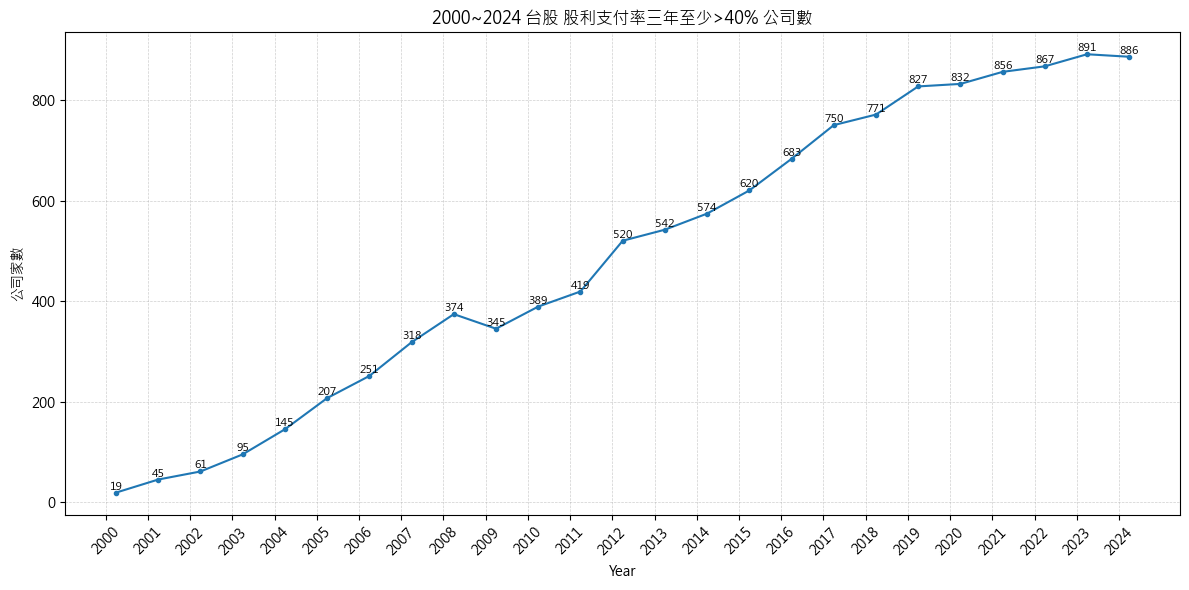

In [44]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = payout_ratio_cond['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 股利支付率三年至少>40% 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


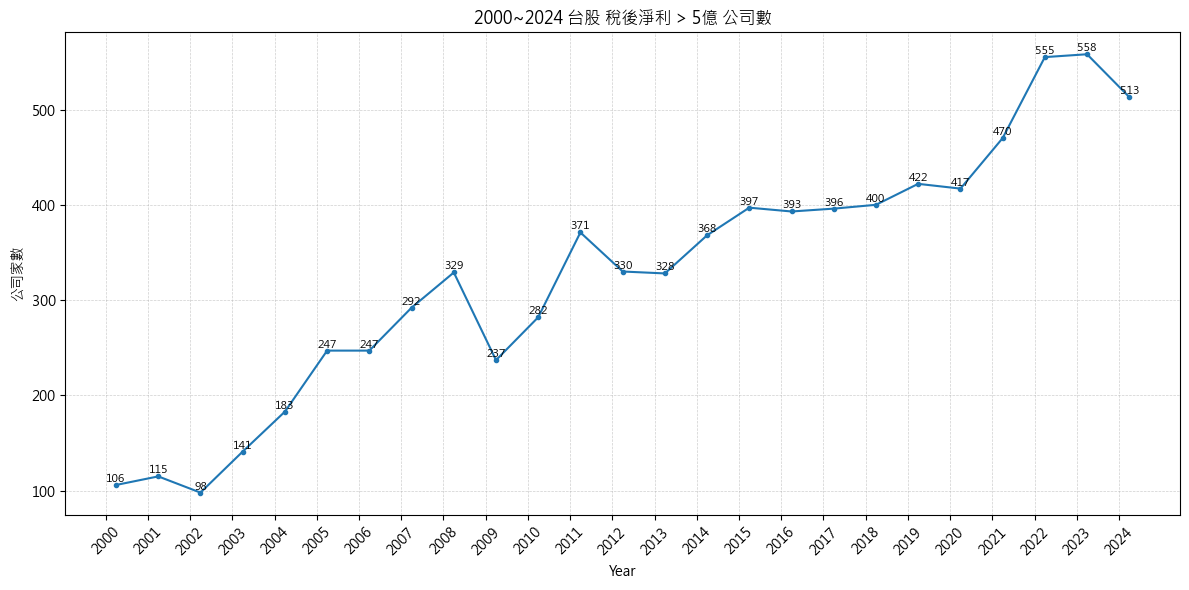

In [45]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = profit_cond['2000':'2024-3']
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 稅後淨利 > 5億 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


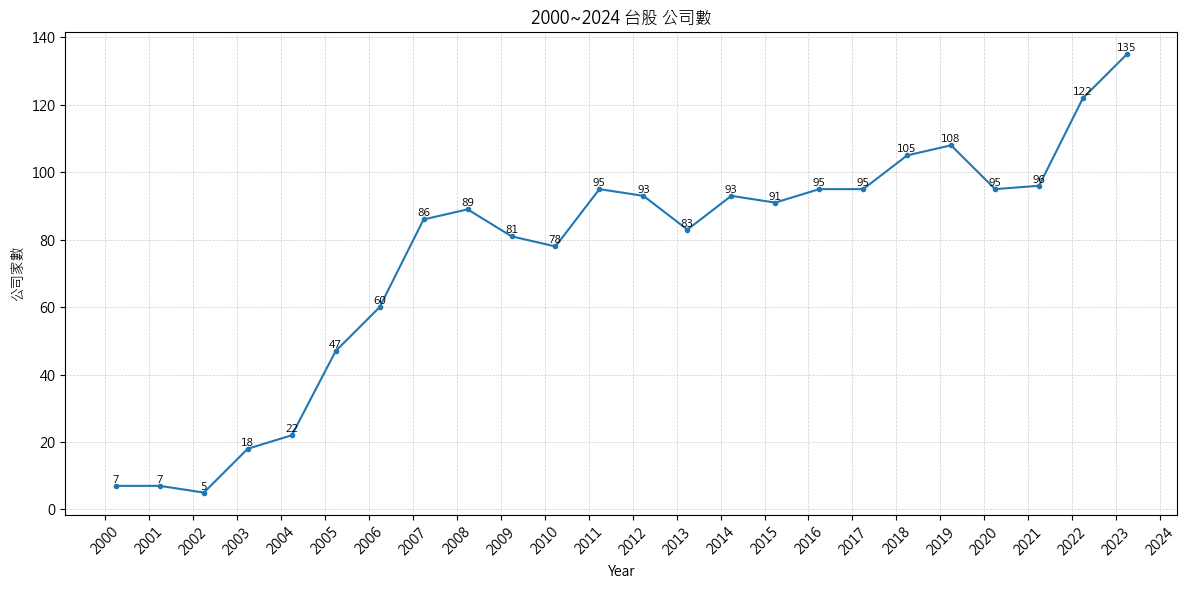

In [46]:
plt.figure(figsize=(12, 6))

# 準備資料
plot_data = (rr_cond & roe_15 & profit_cond)['2000':'2023'] #& close.notna().resample('A-MAR').last()
x = plot_data.index  # X 軸
y = plot_data.sum(axis=1)  # Y 軸

# 繪製折線圖
plt.plot(x, y, marker='o', linestyle='-', markersize=3)

# 設置 X 軸為每年年份
plt.xlabel("Year")
plt.ylabel("公司家數")
plt.title("2000~2024 台股 公司數")
plt.grid(True)
plt.xticks(
    ticks=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS"),
    labels=pd.date_range(start="2000-01-01", end="2024-12-31", freq="YS").strftime("%Y"),
    rotation=45
)

# 在 marker 上添加數字標籤
for i, value in enumerate(y):
    plt.text(x[i], y.iloc[i], str(value), ha='center', va='bottom', fontsize=8)

# 美化圖表
plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()
